# __1. Nhập thư viện__

In [31]:
# # Connect to gg drive
# from google.colab import drive
# drive.mount('/content/drive')

In [32]:
# !pip install keras-tuner
# !pip install scikeras
# !pip install underthesea
# !pip install pyvi
# !pip install import-ipynb

In [33]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import pandas as pd
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
from nltk.corpus import wordnet
import underthesea

import string
import re
import nltk
from underthesea import word_tokenize, pos_tag
from pyvi import ViTokenizer, ViPosTagger
nltk.download('twitter_samples')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet')


from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score



[nltk_data] Downloading package twitter_samples to
[nltk_data]     C:\Users\Nguyen_Thanh_Vinh\AppData\Roaming\nltk_data..
[nltk_data]     .
[nltk_data]   Package twitter_samples is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Nguyen_Thanh_Vinh\AppData\Roaming\nltk_data..
[nltk_data]     .
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\Nguyen_Thanh_Vinh\AppData\Roaming\nltk_data..
[nltk_data]     .
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Nguyen_Thanh_Vinh\AppData\Roaming\nltk_data..
[nltk_data]     .
[nltk_data]   Package wordnet is already up-to-date!


In [34]:
import import_ipynb
import MLTunning as MLT

# __2. Vectorize - word indexing__

In [35]:
def process_tweet(tweet):
    # Tách từ và gán nhãn từ loại
    tweet_tokens = pos_tag(word_tokenize(tweet, format='text'))

    # Xử lý từng từ
    tweets_clean = []
    for word, pos in tweet_tokens:
        if word not in string.punctuation:
            # Gán nhãn từ loại phù hợp
            lemma_word = lemmatizer.lemmatize(word, pos_tag_convert_vietnamese(pos)) # Chuyển về dạng gốc của từ, nếu dùng cho Tiếng Việt thì không cần. Chỉ cần POS tag và chọn từ quan trọng.
            tweets_clean.append(lemma_word)

    return tweets_clean
def pos_tag_convert_vietnamese(tag):
    """
    Chuyển đổi nhãn từ loại của Tiếng Việt sang các nhãn tương ứng trong WordNet
    """
    if tag.startswith('A'):  # Tính từ
        return wordnet.ADJ
    elif tag.startswith('V'):  # Động từ
        return wordnet.VERB
    elif tag.startswith('N'):  # Danh từ
        return wordnet.NOUN
    elif tag.startswith('R'):  # Trạng từ
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [36]:
def build_vocabulary(corpus):
    vocab = {'': 0, '[UNK]': 1}

    for tweet in corpus:
        for word in tweet:
            if word not in vocab:
                vocab[word] = len(vocab)

    return vocab

In [37]:
def max_length(training_x, validation_x):

    max_len = -1
    for tweet in training_x:
        if max_len < len(tweet): max_len = len(tweet)

    for tweet in validation_x:
        if max_len < len(tweet): max_len = len(tweet)

    return max_len

In [38]:
def padded_sequence(tweet, vocab_dict, max_len, unk_token='[UNK]'):
    unk_ID = vocab_dict[unk_token]
    tensor_l = []

    for word in tweet:

        word_ID = vocab_dict[word] if word in vocab_dict else unk_ID
        tensor_l.append(word_ID)

    padded_tensor = tensor_l + [0] * (max_len - len(tensor_l))

    return padded_tensor

# __4. Hyperparameter tunning - DL__

In [39]:
num_words = 0
max_len = 0

In [72]:
import keras_tuner as kt
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dropout, GlobalAveragePooling1D, Dense
from tensorflow.keras.optimizers import Adam

def build_model(hp):
    model = Sequential()
    embedding_dim = 16
    model.add(Embedding(input_dim=num_words, output_dim=embedding_dim, input_length=max_len))

    for _ in range(hp.Int('num_lstm_layers', 1, 3)):
        model.add(LSTM(hp.Int('lstm_units', 32, 128, step=32), return_sequences=True))
        model.add(Dropout(0.5))

    model.add(GlobalAveragePooling1D())
    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')),
        metrics=['accuracy']
    )
    return model

# __5. Phân tích đánh giá câu dài - data full__

### ___5.1. Đọc và tiền xử lý dữ liệu___

In [41]:
file_path = r'C:\\Users\\Nguyen_Thanh_Vinh\\Downloads\\NopThay\\preprocessed_data.xlsx'
df = pd.read_excel(file_path)
df.head()

,content_comments,comment_eng,sentiment,word_tokenize
0,thay đổi coment tăng size hãy làm như bạn muố...,Change the cmt to increase 1 size. Please do a...,0,thay_đổi coment tăng size hãy làm như bạn muốn...
1,quần dày mỗi lần size nhỏ nhắn tin cửa hàng đổ...,"thick pants\nEvery time the size is small, mes...",0,quần dày mỗi lần size nhỏ_nhắn tin cửa_hàng đổ...
2,đã nhận được đóng gói màu đúng mẫu đúng sau sẽ...,Received the goods...shop packaged quickly...r...,1,đã nhận được đóng_gói màu đúng mẫu đúng sau sẽ...
3,đã nhận được đóng gói sizesẽ khả năng quay lại...,Received the goods...shop packaged quickly...r...,1,đã nhận được đóng_gói sizesẽ khả_năng quay lại...
4,hình ảnh nhận xu và quan đơn giản thôi mua nhi...,The picture of receipt of coin and quan is sim...,0,hình_ảnh nhận xu và quan đơn_giản thôi mua nhi...


### ___5.2. text vectorizer - word index - Full___

In [42]:
all_tweets = df['word_tokenize']
all_tweets = [str(t) if not isinstance(t, str) else t for t in all_tweets]
all_tweets

['thay_đổi coment tăng size hãy làm như bạn muốn bạn có muốn điện_thoại của mình tăng lên kích_cỡ không đàn hồi dày tui ziper vừa size xin_lỗi',
 'quần dày mỗi lần size nhỏ_nhắn tin cửa_hàng đổi size lớn hơn nhưng cửa_hàng không trả đang làm_ăn rất tệ',
 'đã nhận được đóng_gói màu đúng mẫu đúng sau sẽ khả_năng quay lại ủng_hộ các bạn ủng_hộ',
 'đã nhận được đóng_gói sizesẽ khả_năng quay lại ủng_hộ cửa_hàng lần sauhãy ghé ủng_hộ cửa_hàng nhé',
 'hình_ảnh nhận xu và quan đơn_giản thôi mua nhiều lần rồi nhưng lần này vải có_vẻ mỏng hơn lần trước thì mua ở đâu nhỉ',
 'nếu bạn đang bị quầng thâm và bọng mắt như tôi thì hãy đi điều_trị ngay đây tôi từng bị stres vì đôi mắt thâm_quầng và bọng_mắt khủng_khiếp tôi sinh ra đã mắc bệnh này ngủ sớm cũng gây ra ngủ quá nhiều cũng gây ra_mắt lúc_nào cũng đen_😞 nhìn rất khó cũng đã thử mua loại kem này kem nọ về bôi nhưng không hiệu_quả nên không đi_nữa bác_sĩ quyết_tâm chữa khỏi cho yên_tâm may_mắn được một người bạn giới_thiệu đến phòng_khám bác_sĩ

In [43]:
all_tweets_processed = [process_tweet(tweet) for tweet in all_tweets]

In [44]:
# prompt: Tạo mảng x lưu trữ các giá trị trong cột word_tokenize và mảng y lưu trữ giá trị trong cột sentiment

x = all_tweets_processed
y = df['sentiment'].values

from sklearn.model_selection import train_test_split
train_x, val_x, train_y, val_y = train_test_split(x, y, test_size = 0.2, random_state = 42)

print(f"There are {len(train_x)} sentences for training.")
print(f"There are {len(train_y)} labels for training.\n")
print(f"There are {len(val_x)} sentences for validation.")
print(f"There are {len(val_y)} labels for validation.")

There are 832 sentences for training.
There are 832 labels for training.

There are 208 sentences for validation.
There are 208 labels for validation.


In [45]:
vocab = build_vocabulary(train_x)
num_words = len(vocab)
print(f"Vocabulary contains {num_words} words\n")
print(vocab)

Vocabulary contains 1831 words

{'': 0, '[UNK]': 1, 'giao': 2, 'hàng': 3, 'đúng': 4, 'túi': 5, 'có': 6, 'khóa': 7, 'kéo': 8, 'tiện_lợi': 9, 'để': 10, 'đựng': 11, 'điện_thoại': 12, 'vừa': 13, 'vặn': 14, 'và': 15, 'chất_lượng': 16, 'chuẩn_bị': 17, 'mất': 18, 'nhiều': 19, 'thời_gian': 20, '😡 __hủy': 21, 'hàng_không': 22, 'nhận': 23, 'thì': 24, 'làm_sao': 25, 'kinh_doanh': 26, 'được': 27, '🖕': 28, 'không': 29, 'giống': 30, 'mẫu': 31, 'đẹp': 32, 'mô_tả': 33, 'lần': 34, 'sau': 35, 'sẽ': 36, 'mua': 37, 'tiếp': 38, 'giá': 39, 'rẻ': 40, 'nên': 41, 'áo': 42, 'ấn_tượng': 43, 'chất': 44, 'vải': 45, 'mỏng_mát': 46, 'mùa': 47, 'hè': 48, 'nhưng': 49, 'quần': 50, 'mỏng': 51, 'quá': 52, 'lộ': 53, 'cả': 54, 'bên': 55, 'trong': 56, 'đường': 57, 'may_cẩu_thả': 58, 'giặt': 59, 'cẩn_thận': 60, 'có_thể': 61, 'dễ_dàng': 62, 'khiến': 63, 'sợi': 64, 'chỉ': 65, 'bị': 66, 'bung': 67, 'ra': 68, 'bộ': 69, 'này': 70, 'có_lẽ': 71, 'bền': 72, 'hơn': 73, 'nếu': 74, 'bạn': 75, 'tay': 76, 'cửa_hàng': 77, 'nhanh_chóng': 7

In [46]:
max_len = max_length(train_x, val_x)
print(f'The length of the longest tweet is {max_len} tokens.')

The length of the longest tweet is 150 tokens.


In [47]:
train_x_padded = [padded_sequence(x, vocab, max_len) for x in train_x]
val_x_padded = [padded_sequence(x, vocab, max_len) for x in val_x]

### ___5.3. Mô hình học máy - Logistic regression___

c:\Users\Nguyen_Thanh_Vinh\anaconda3\envs\RP_Env\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Nguyen_Thanh_Vinh\anaconda3\envs\RP_Env\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Nguyen_Thanh_Vinh\anaconda3\envs\RP_Env\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Nguyen_Thanh_Vinh\anaconda3\envs\RP_Env\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Nguyen_Thanh_Vinh\anaconda3\envs\RP_Env\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warni

Best hyperparameters (Logistic regression): {'solver': 'saga', 'penalty': 'l2', 'C': 100}
Best score (Logistic regression): 0.632191039607532
Best Logistic regression Accuracy: 0.6009615384615384
Best Logistic regression Precision: 0.7477477477477478
Best Logistic regression Recall: 0.6014492753623188
Best Logistic regression AUC: 0.5903687192346987

Classification Report:  LogisticRegression
              precision    recall  f1-score   support

           0       0.60      0.43      0.50        97
           1       0.60      0.75      0.67       111

    accuracy                           0.60       208
   macro avg       0.60      0.59      0.58       208
weighted avg       0.60      0.60      0.59       208

ROC_AUC_SCORE is  0.5903687192346987


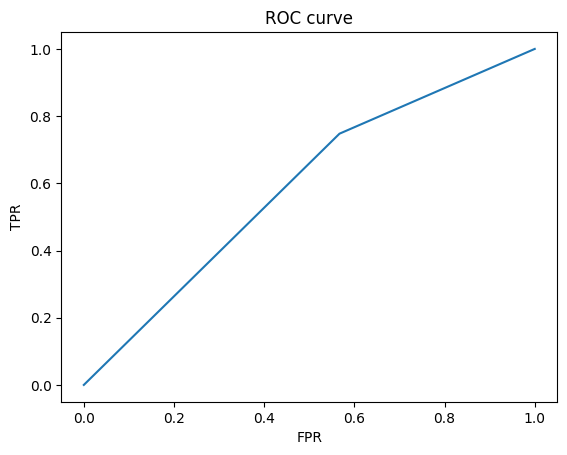

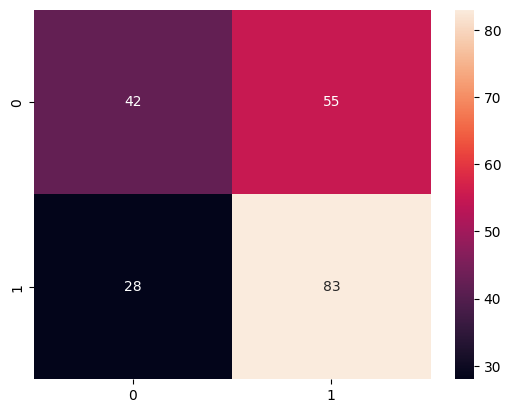

In [48]:
logreg_results = MLT.tune_logistic_regression(train_x_padded, train_y, val_x_padded, val_y)

In [49]:
best_logreg_model_split = logreg_results[0]

### ___5.4. Mô hình học máy - Random forest___

c:\Users\Nguyen_Thanh_Vinh\anaconda3\envs\RP_Env\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
25 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Nguyen_Thanh_Vinh\anaconda3\envs\RP_Env\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Nguyen_Thanh_Vinh\anaconda3\envs\RP_Env\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "c:\Users\Nguyen_Thanh_Vinh\anaconda3\envs\RP_Env\Lib\site-packages\sklearn\base.py", line 666, in _validat

Best hyperparameters (RandomForestClassifier): {'max_depth': 37, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 9, 'n_estimators': 73}
Best score (RandomForestClassifier): 0.6899213620950869
Best Random Forest Accuracy: 0.7259615384615384
Best Random Forest Precision: 0.8738738738738738
Best Random Forest Recall: 0.6928571428571428
Best Random Forest AUC: 0.7152874524008545
Classification Report:  RandomForestClassifier
              precision    recall  f1-score   support

           0       0.79      0.56      0.65        97
           1       0.69      0.87      0.77       111

    accuracy                           0.73       208
   macro avg       0.74      0.72      0.71       208
weighted avg       0.74      0.73      0.72       208

ROC_AUC_SCORE is  0.7152874524008545


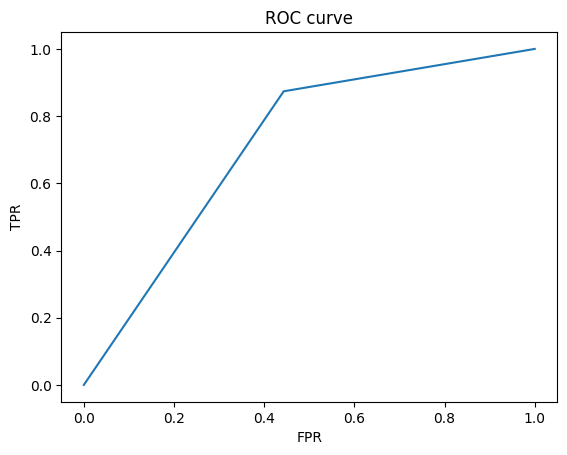

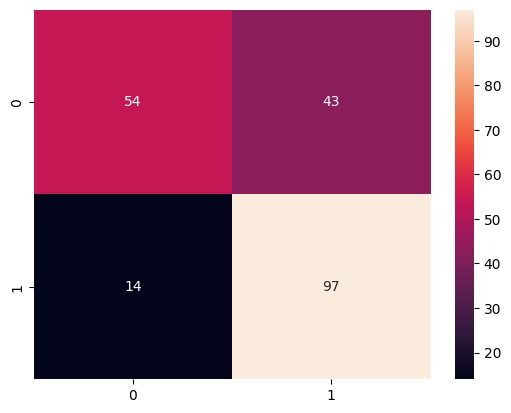

In [50]:
rf_results = MLT.tune_random_forest(train_x_padded, train_y, val_x_padded, val_y)

In [51]:
best_rf_model_split = rf_results[0]

### ___5.5. Mô hình học máy - Navie Bayes___

Best hyperparameters (MultinomialNB): {'alpha': 9.756545571902027}
Best score (MultinomialNB): 0.556640934997475
Best Navie Bayes Accuracy: 0.5673076923076923
Best Naive Bayes Precision: 0.38738738738738737
Best Navie Bayes Recall: 0.6615384615384615
Best Naive Bayes AUC: 0.5802916318380237
Classification Report:  MultinomialNB
              precision    recall  f1-score   support

           0       0.52      0.77      0.62        97
           1       0.66      0.39      0.49       111

    accuracy                           0.57       208
   macro avg       0.59      0.58      0.56       208
weighted avg       0.60      0.57      0.55       208

ROC_AUC_SCORE is  0.5802916318380237


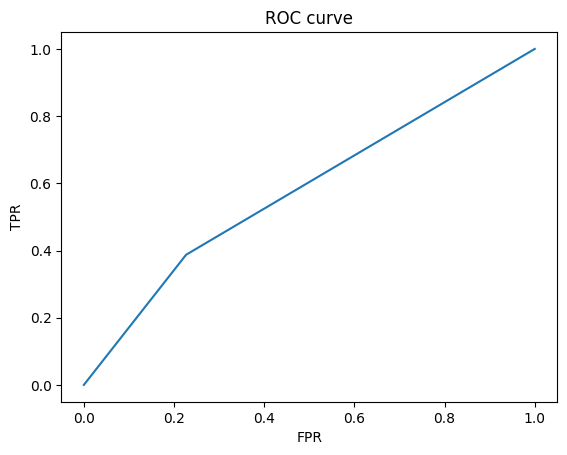

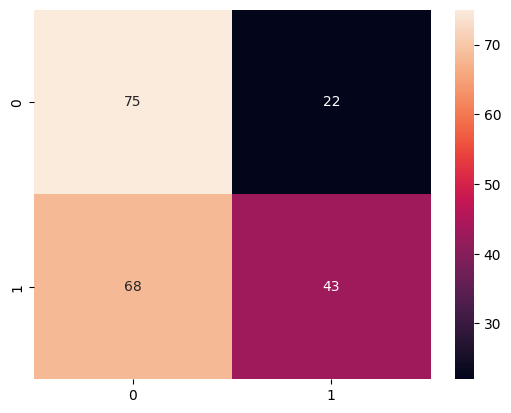

In [52]:
nb_results = MLT.tune_multinomial_nb(train_x_padded, train_y, val_x_padded, val_y)

In [53]:
best_nb_results_split = nb_results[0]

### ___5.6. Mô hình học sâu - LSTM___

In [54]:
train_x_prepared = np.array(train_x_padded)
val_x_prepared = np.array(val_x_padded)

train_y_prepared = np.array(train_y)
val_y_prepared = np.array(val_y)

In [76]:
base_dir = r'sentiment_NK3'
project_name = 'intro_to_kt3'
directory = os.path.join(base_dir, project_name)

if not os.path.exists(directory):
    os.makedirs(directory)
    print(f"Created directory: {directory}")
else:
    print(f"Directory already exists: {directory}")

tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=1,
    directory=base_dir,
    project_name=project_name
)

# Tiến hành tìm kiếm siêu tham số
tuner.search(train_x_prepared, train_y_prepared, epochs=10, validation_data=(val_x_prepared, val_y_prepared))

Trial 5 Complete [00h 01m 16s]
val_accuracy: 0.5336538553237915

Best val_accuracy So Far: 0.9471153616905212
Total elapsed time: 00h 06m 07s


In [77]:
# Lấy các siêu tham số tốt nhất
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best hyperparameters found:")
print(f"LSTM units: {best_hps.get('lstm_units')}")
print(f"Number of LSTM layers: {best_hps.get('num_lstm_layers')}")
print(f"Learning rate: {best_hps.get('learning_rate')}")

Best hyperparameters found:
LSTM units: 64
Number of LSTM layers: 1
Learning rate: 0.0022261711101035104


# __6. Phân tích đánh giá câu ngắn - data split__

### ___6.1. Đọc và tiền xử lý dữ liệu___

In [56]:
file_path1 = r'C:\\Users\\Nguyen_Thanh_Vinh\\Downloads\\NopThay\\preprocessed_data1.xlsx'
df1 = pd.read_excel(file_path1)
print(df1.head())

   Unnamed: 0                                            comment  \
0         3.0                                           thun dày   
1         4.0                                    túi có khóa kéo   
2         NaN  mỗi lần size nhỏ nhắn cửa hàng đổi size to hơn...   
3         8.0                                           quần dày   
4         9.0                                  đã nhận được hàng   

   sentiment_manual                                      word_tokenize  
0                 1                                           thun dày  
1                 1                                    túi có khóa kéo  
2                 0  mỗi lần size nhỏ_nhắn cửa_hàng đổi size to hơn...  
3                 1                                           quần dày  
4                 1                                  đã nhận được hàng  


### ___6.2. text vectorizer - word index - split___

In [57]:
all_tweets1 = df1['word_tokenize']
all_tweets1 = [str(t) if not isinstance(t, str) else t for t in all_tweets1]

In [58]:
all_tweets_processed1 = [process_tweet(tweet) for tweet in all_tweets1]

In [59]:
# prompt: Tạo mảng x lưu trữ các giá trị trong cột word_tokenize và mảng y lưu trữ giá trị trong cột sentiment

x1 = all_tweets_processed1
y1 = df1['sentiment_manual'].values


from sklearn.model_selection import train_test_split
train_x1, val_x1, train_y1, val_y1 = train_test_split(x1, y1, test_size = 0.2, random_state = 42)

print(f"There are {len(train_x1)} sentences for training.")
print(f"There are {len(train_y1)} labels for training.\n")
print(f"There are {len(val_x1)} sentences for validation.")
print(f"There are {len(val_y1)} labels for validation.")


There are 6788 sentences for training.
There are 6788 labels for training.

There are 1697 sentences for validation.
There are 1697 labels for validation.


In [60]:
vocab1 = build_vocabulary(train_x1)
num_words1 = len(vocab1)
print(f"Vocabulary contains {num_words1} words\n")
print(vocab1)

Vocabulary contains 1977 words

{'': 0, '[UNK]': 1, 'tôi': 2, 'phải': 3, 'mua': 4, 'một': 5, 'chiếc': 6, 'áo': 7, 'khác': 8, 'để': 9, 'mặc': 10, 'túi': 11, 'khóa': 12, 'kéo': 13, 'tiện_lợi': 14, 'đựng': 15, 'điện_thoại': 16, 'mình': 17, 'nghĩ': 18, 'thêu': 19, 'thì': 20, 'đẹp': 21, 'hơn': 22, 'gói': 23, 'hàng': 24, 'cẩn_thận': 25, 'sale': 26, 'giá': 27, 'tốt': 28, 'cảm_giác': 29, 'như': 30, 'đồ': 31, 'cũ': 32, 'vậy': 33, '🤔 __sao': 34, 'vì': 35, 'sự': 36, 'bất_cẩn': 37, 'lại': 38, 'rẻ': 39, 'bất_ngờ': 40, 'lãng_phí': 41, 'tiền': 42, 'nhưng_mà': 43, 'nó': 44, 'chỉ': 45, 'là': 46, 'sản_phẩm': 47, 'may_đo': 48, 'thôi': 49, 'cửa_hàng': 50, 'tư_vấn': 51, 'chọn': 52, 'size': 53, 'vừa': 54, 'vặn': 55, 'áp_dụng': 56, 'mã': 57, 'đừng': 58, 'mà': 59, 'mất': 60, 'chất_lượng': 61, 'đặt': 62, 'xin_lỗi': 63, 'nhưng': 64, 'nhận': 65, 'được': 66, 'xl': 67, 'đã': 68, 'bị': 69, 'xóa': 70, 'thành': 71, 'giao': 72, 'đúng': 73, 'mẫu': 74, 'và': 75, 'rất': 76, 'đáng': 77, 'ở': 78, 'nhà': 79, 'cũng': 80, 'ổn

In [61]:
max_len1 = max_length(train_x1, val_x1)
print(f'The length of the longest tweet is {max_len1} tokens.')

The length of the longest tweet is 59 tokens.


In [62]:
train_x_padded1 = [padded_sequence(x, vocab1, max_len1) for x in train_x1]
val_x_padded1 = [padded_sequence(x, vocab1, max_len1) for x in val_x1]

### ___6.3. Mô hình học máy - Logistic regression - split___

c:\Users\Nguyen_Thanh_Vinh\anaconda3\envs\RP_Env\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Nguyen_Thanh_Vinh\anaconda3\envs\RP_Env\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Nguyen_Thanh_Vinh\anaconda3\envs\RP_Env\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Nguyen_Thanh_Vinh\anaconda3\envs\RP_Env\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Nguyen_Thanh_Vinh\anaconda3\envs\RP_Env\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warni

Best hyperparameters (Logistic regression): {'solver': 'saga', 'penalty': 'l2', 'C': 100}
Best score (Logistic regression): 0.743665800957887
Best Logistic regression Accuracy: 0.7354154390100177
Best Logistic regression Precision: 0.9713831478537361
Best Logistic regression Recall: 0.7474006116207951
Best Logistic regression AUC: 0.515304330191105

Classification Report:  LogisticRegression
              precision    recall  f1-score   support

           0       0.42      0.06      0.10       439
           1       0.75      0.97      0.84      1258

    accuracy                           0.74      1697
   macro avg       0.58      0.52      0.47      1697
weighted avg       0.66      0.74      0.65      1697

ROC_AUC_SCORE is  0.515304330191105


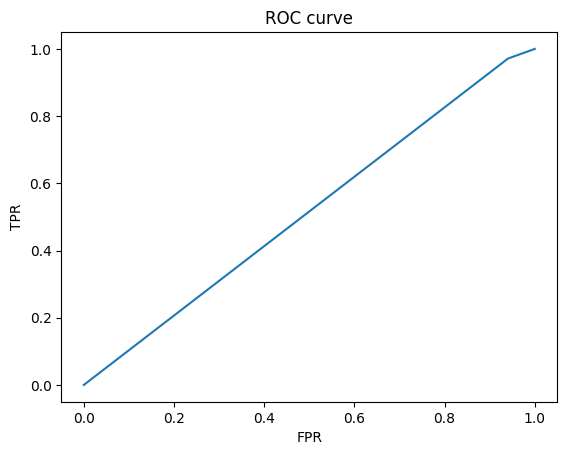

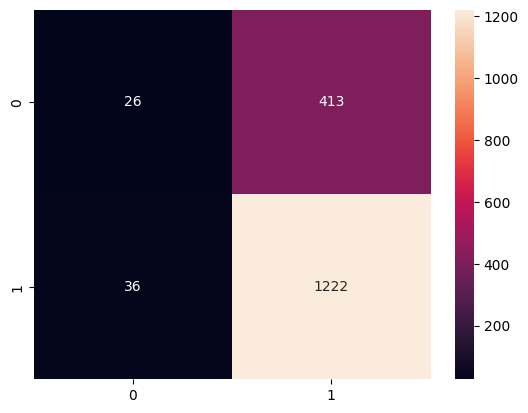

In [63]:
logreg_results = MLT.tune_logistic_regression(train_x_padded1, train_y1, val_x_padded1, val_y1)

In [64]:
best_logreg_model_split = logreg_results[0]

### ___6.4. Mô hình học máy - Random forest - split___

c:\Users\Nguyen_Thanh_Vinh\anaconda3\envs\RP_Env\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
15 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Nguyen_Thanh_Vinh\anaconda3\envs\RP_Env\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Nguyen_Thanh_Vinh\anaconda3\envs\RP_Env\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "c:\Users\Nguyen_Thanh_Vinh\anaconda3\envs\RP_Env\Lib\site-packages\sklearn\base.py", line 666, in _validat

Best hyperparameters (RandomForestClassifier): {'max_depth': 42, 'max_features': 'log2', 'min_samples_leaf': 3, 'min_samples_split': 6, 'n_estimators': 197}
Best score (RandomForestClassifier): 0.7555996670295191
Best Random Forest Accuracy: 0.7690041249263406
Best Random Forest Precision: 0.9705882352941176
Best Random Forest Recall: 0.774746192893401
Best Random Forest AUC: 0.5809660994238242
Classification Report:  RandomForestClassifier
              precision    recall  f1-score   support

           0       0.69      0.19      0.30       439
           1       0.77      0.97      0.86      1258

    accuracy                           0.77      1697
   macro avg       0.73      0.58      0.58      1697
weighted avg       0.75      0.77      0.72      1697

ROC_AUC_SCORE is  0.5809660994238242


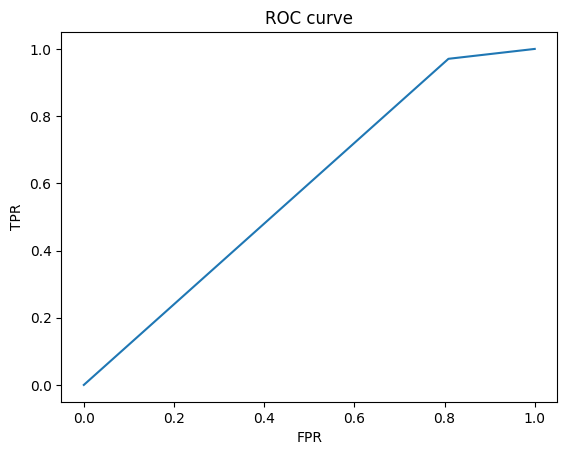

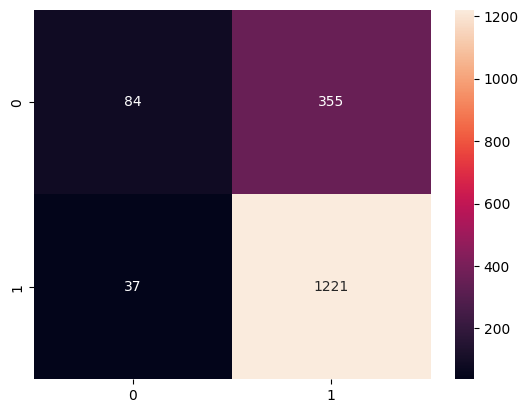

In [65]:
rf_results = MLT.tune_random_forest(train_x_padded1, train_y1, val_x_padded1, val_y1)

In [66]:
best_rf_model_split = rf_results[0]

### ___6.5. Mô hình học máy - Navie Bayes - split___

Best hyperparameters (MultinomialNB): {'alpha': 6.114762302756431}
Best score (MultinomialNB): 0.7225990147633554
Best Navie Bayes Accuracy: 0.7189157336476134
Best Naive Bayes Precision: 0.8839427662957074
Best Navie Bayes Recall: 0.7706167706167706
Best Naive Bayes AUC: 0.5649782168608377
Classification Report:  MultinomialNB
              precision    recall  f1-score   support

           0       0.43      0.25      0.31       439
           1       0.77      0.88      0.82      1258

    accuracy                           0.72      1697
   macro avg       0.60      0.56      0.57      1697
weighted avg       0.68      0.72      0.69      1697

ROC_AUC_SCORE is  0.5649782168608377


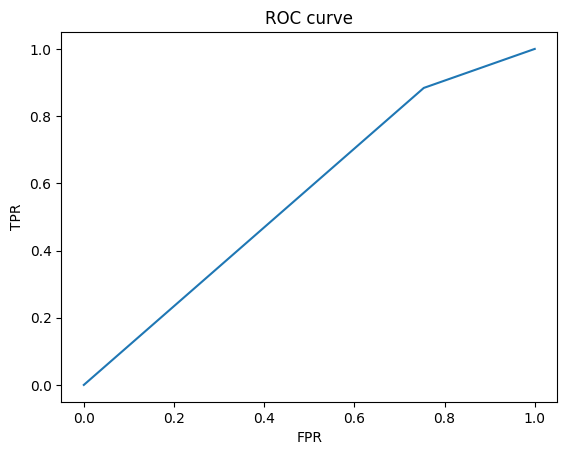

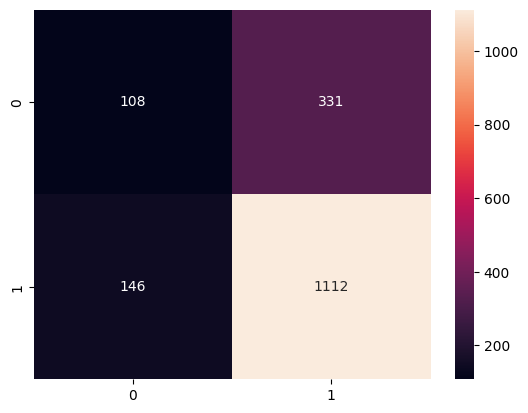

In [67]:
nb_results = MLT.tune_multinomial_nb(train_x_padded1, train_y1, val_x_padded1, val_y1)

In [68]:
best_nb_results_split = nb_results[0]

### ___6.6. Mô hình học sâu - LSTM - split___

In [84]:
train_x_prepared1 = np.array(train_x_padded1)
val_x_prepared1 = np.array(val_x_padded1)

train_y_prepared1 = np.array(train_y1)
val_y_prepared1 = np.array(val_y1)

In [85]:
def build_model(hp):
    model = Sequential()
    embedding_dim = 16
    model.add(Embedding(input_dim=num_words1, output_dim=embedding_dim, input_length=max_len1))

    for _ in range(hp.Int('num_lstm_layers', 1, 3)):
        model.add(LSTM(hp.Int('lstm_units', 32, 128, step=32), return_sequences=True))
        model.add(Dropout(0.5))

    model.add(GlobalAveragePooling1D())
    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')),
        metrics=['accuracy']
    )
    return model

In [86]:
base_dir = r'sentiment_NKK'
project_name = 'intro_to_ktt'
directory = os.path.join(base_dir, project_name)

if not os.path.exists(directory):
    os.makedirs(directory)
    print(f"Created directory: {directory}")
else:
    print(f"Directory already exists: {directory}")

tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=1,
    directory=base_dir,
    project_name=project_name
)

# Tiến hành tìm kiếm siêu tham số
tuner.search(train_x_prepared1, train_y_prepared1, epochs=20, validation_data=(val_x_prepared1, val_y_prepared1))

Trial 5 Complete [00h 10m 30s]
val_accuracy: 0.9033588767051697

Best val_accuracy So Far: 0.9033588767051697
Total elapsed time: 00h 24m 56s


In [87]:
# Lấy các siêu tham số tốt nhất
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best hyperparameters found:")
print(f"LSTM units: {best_hps.get('lstm_units')}")
print(f"Number of LSTM layers: {best_hps.get('num_lstm_layers')}")
print(f"Learning rate: {best_hps.get('learning_rate')}")

Best hyperparameters found:
LSTM units: 64
Number of LSTM layers: 3
Learning rate: 0.005300696019167498
